### 필요한 라이브러리 불러오기

In [16]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

from matplotlib import pyplot as plt
import seaborn as sn
import pandas as pd
import numpy as np
import os

device = 'cuda'

### 데이터세트 다운로드 및 불러오기

In [17]:

transform_train = transforms.Compose([
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=4)

In [18]:
def train(net, epoch, optimizer, critierion, train_loader):
  print('[Train epoch: %d]' % epoch)
  net.train()
  train_loss = 0
  correct = 0
  total = 0
  for batch_idx, (inputs, targets) in enumerate(train_loader):
      inputs, targets = inputs.to(device), targets.to(device)
      optimizer.zero_grad()

      benign_outputs = net(inputs)
      loss = criterion(benign_outputs, targets)
      loss.backward()

      optimizer.step()
      train_loss += loss.item()
      _, predicted = benign_outputs.max(1)

      total += targets.size(0)
      correct += predicted.eq(targets).sum().item()

  print('Train accuarcy:', 100. * correct / total)
  print('Train average loss:', train_loss / total)
  return (100. * correct / total, train_loss / total)

def evaluate(net, epoch, file_name, data_loader, info):
    print('[ Evaluate epoch: %d ]' % epoch)
    print("Dataset:", info)

    net.eval() # Dropout을 적용하는 경우 필수임
    test_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(data_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        total += targets.size(0)

        outputs = net(inputs)
        test_loss += criterion(outputs, targets).item()

        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()

    print('Accuarcy:', 100. * correct / total)
    print('Average loss:', test_loss / total)
    return (100. * correct / total, test_loss / total)

### 혼동행렬 (Confusion Matrix) 정의

In [19]:
def get_confusion_matrix(net, num_classes, data_loader):
    confusion_matrix = torch.zeros(num_classes, num_classes)

    net.eval() # Dropout을 적용하는 경우 필수임

    for batch_idx, (inputs, targets) in enumerate(data_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = net(inputs)
        _, predicted = outputs.max(1)

        for t, p in zip(targets.view(-1), predicted.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

    return confusion_matrix

### LeNet 모델 정의
- LeNet 모델 아키텍처는 아래 그림과 같음
- PyTorch 가 공식적으로 제공하는 LeNet 아키텍처와는 차이가 있음.


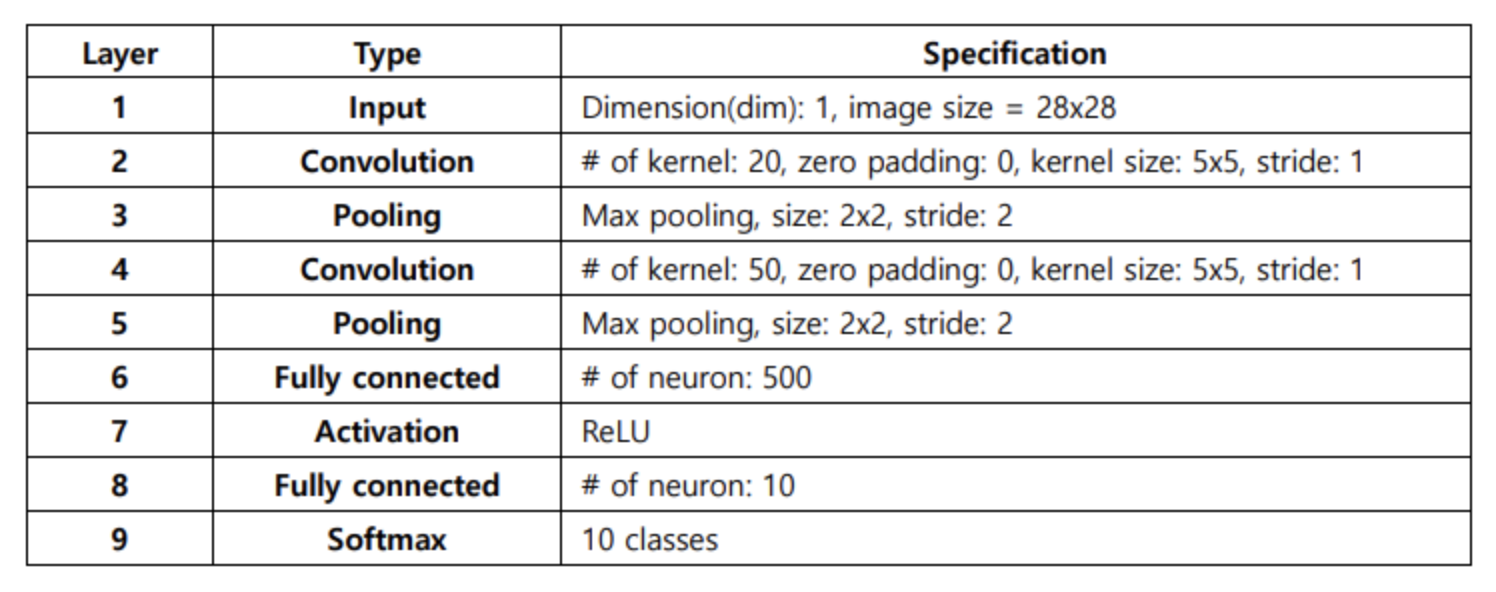

In [20]:
class LeNet(nn.Module):
    # 실제로 가중치가 존재하는 레이어만 객체로 만들기
    def __init__(self):
        super(LeNet, self).__init__()
        # 여기에서 (1 x 28 x 28)
        # 입력 채널: 1, 출력 채널: 20 (커널 20개)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, stride=1, padding=0)
        # 여기에서 (20 x 24 x 24)
        # 풀링 이후에 (20 x 12 x 12)
        # 입력 채널: 20, 출력 채널: 50 (커널 50개)
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=50, kernel_size=5, stride=1, padding=0)
        # 여기에서 (50 x 8 x 8)
        # 풀링 이후에 (50 x 4 x 4)
        self.fc1 = nn.Linear(50 * 4 * 4, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.max_pool2d(self.conv1(x), (2, 2))
        x = F.max_pool2d(self.conv2(x), (2, 2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    # 3차원의 컨볼루션 레이어를 flatten
    def num_flat_features(self, x):
        size = x.size()[1:] # 배치는 제외하고
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


### AlexNet 모델 정의
- AlexNet 모델 아키텍처는 아래 그림과 같다.
  - PyTorch 가 공식적으로 제공하는 AlexNet 아케텍처와는 차이가 있음

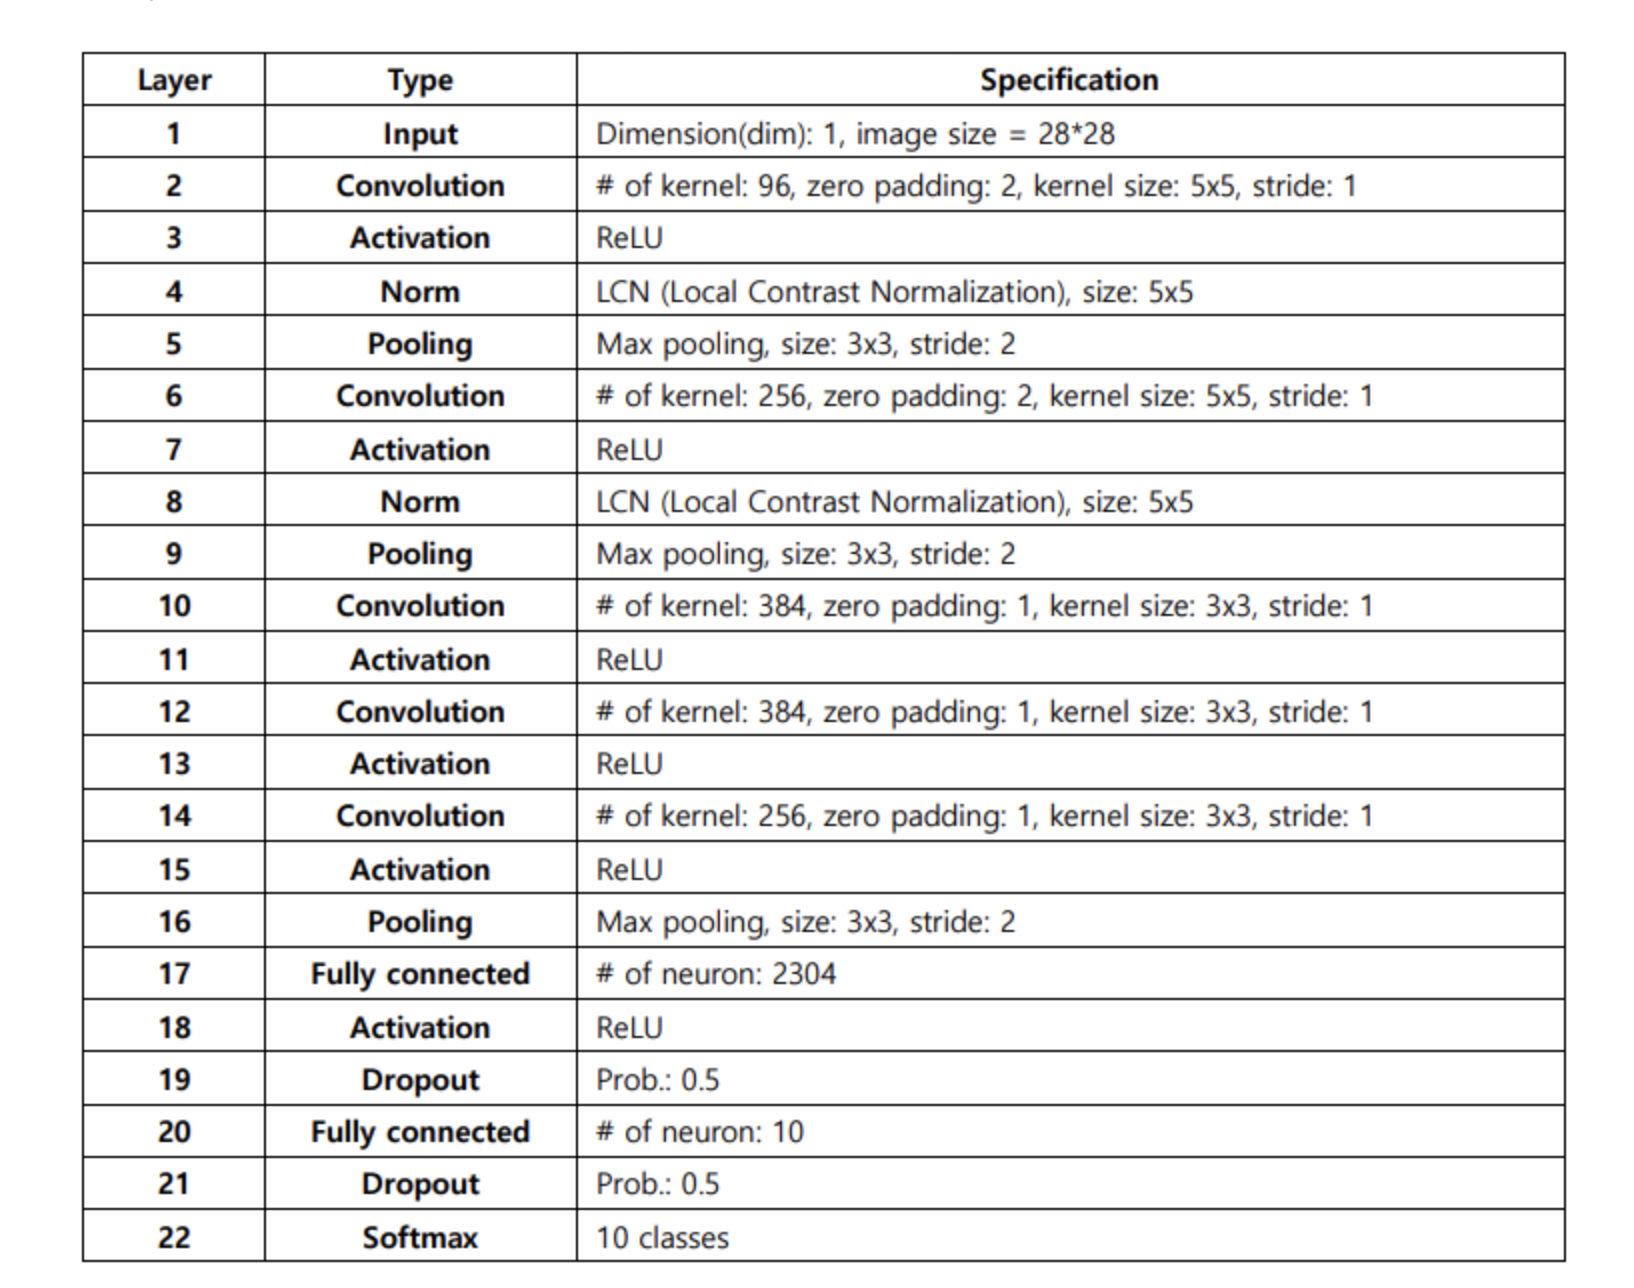

In [21]:
class LocalResponseNorm(nn.Module):
    def __init__(self, size, alpha = 1e-4, beta = 0.75, k = 1.0):
        super(LocalResponseNorm, self).__init__()
        self.size = size
        self.alpha = alpha
        self.beta = beta
        self.k = k

    def forward(self, input):
        return F.local_response_norm(input, self.size, self.alpha, self.beta, self.k)

In [22]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            # 여기에서 (1 x 28 x 28)
            # 입력 채널: 1, 출력 채널: 96 (커널 96개)
            nn.Conv2d(1, 96, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            LocalResponseNorm(size=5),
            # 여기에서 (96 x 28 x 28)
            nn.MaxPool2d(kernel_size=3, stride=2),
            # 여기에서 (96 x 13 x 13)
            # 입력 채널: 96, 출력 채널: 256 (커널 256개)
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            LocalResponseNorm(size=5),
            # 여기에서 (256 x 13 x 13)
            nn.MaxPool2d(kernel_size=3, stride=2),
            # 여기에서 (256 x 6 x 6)
            # 입력 채널: 256, 출력 채널: 384 (커널 384개)
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            # 여기에서 (384 x 6 x 6)
            nn.ReLU(inplace=True),
            # 입력 채널: 384, 출력 채널: 384 (커널 384개)
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            # 여기에서 (384 x 6 x 6)
            nn.ReLU(inplace=True),
            # 입력 채널: 384, 출력 채널: 384 (커널 384개)
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            # 여기에서 (384 x 6 x 6)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            # 여기에서 (384 x 2 x 2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(384 * 2 * 2, 2304),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(2304, 10),
            nn.Dropout(),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

### 결과 확인 : LeNet 결과 분석

In [25]:
net = LeNet()
net = net.to(device)

epoch = 10
learning_rate = 0.01
file_name = "LeNet_MNIST.pt"

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

train_result = []
test_result = []

train_result.append(evaluate(net, 0, file_name, train_loader, "Train"))
test_result.append(evaluate(net, 0, file_name, test_loader, "Test"))

for i in range(epoch):
    train(net, i, optimizer, criterion, train_loader)
    train_acc, train_loss = evaluate(net, i + 1, file_name, train_loader, "Train")
    test_acc, test_loss = evaluate(net, i + 1, file_name, test_loader, "Test")

    state = {
        'net': net.state_dict()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print('Model Saved!')

    train_result.append((train_acc, train_loss))
    test_result.append((test_acc, test_loss))

[ Evaluate epoch: 0 ]
Dataset: Train
Accuarcy: 11.463333333333333
Average loss: 0.018026911207040152
[ Evaluate epoch: 0 ]
Dataset: Test
Accuarcy: 11.01
Average loss: 0.023062100148200988
[Train epoch: 0]
Train accuarcy: 88.17333333333333
Train average loss: 0.0032251807016630968
[ Evaluate epoch: 1 ]
Dataset: Train
Accuarcy: 96.27166666666666
Average loss: 0.0009501807615781824
[ Evaluate epoch: 1 ]
Dataset: Test
Accuarcy: 96.71
Average loss: 0.0010790099140256643
Model Saved!
[Train epoch: 1]
Train accuarcy: 97.45
Train average loss: 0.0006477744319010526
[ Evaluate epoch: 2 ]
Dataset: Train
Accuarcy: 98.135
Average loss: 0.0004939447690111895
[ Evaluate epoch: 2 ]
Dataset: Test
Accuarcy: 97.94
Average loss: 0.0006355858530849219
Model Saved!
[Train epoch: 2]
Train accuarcy: 98.285
Train average loss: 0.0004414130988918866
[ Evaluate epoch: 3 ]
Dataset: Train
Accuarcy: 98.65666666666667
Average loss: 0.0003423356835730374
[ Evaluate epoch: 3 ]
Dataset: Test
Accuarcy: 98.57
Average lo

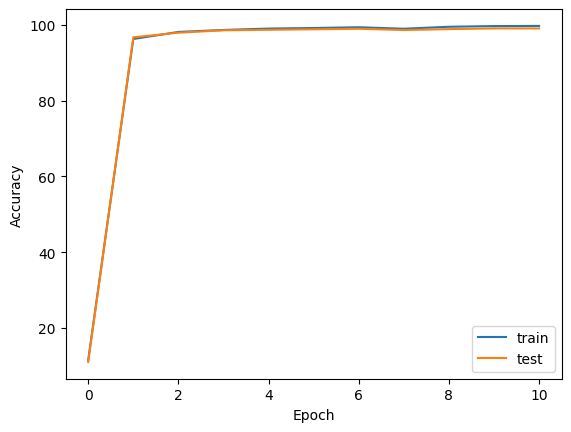

In [26]:
# 정확도(accuracy) 커브 시각화
plt.plot([i for i in range(epoch + 1)], [i[0] for i in train_result])
plt.plot([i for i in range(epoch + 1)], [i[0] for i in test_result])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["train", "test"])
plt.show()

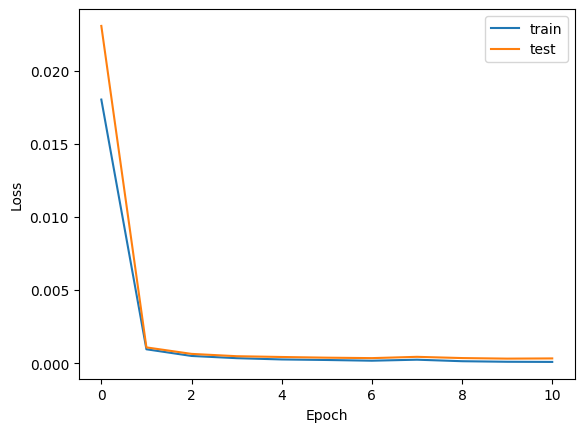

In [28]:
# 손실(loss) 커브 시각화
plt.plot([i for i in range(epoch + 1)], [i[1] for i in train_result])
plt.plot([i for i in range(epoch + 1)], [i[1] for i in test_result])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "test"])
plt.show()

[ 각 클래스당 데이터 개수 ]
tensor([5923., 6742., 5958., 6131., 5842., 5421., 5918., 6265., 5851., 5949.])
[ 혼동 행렬(confusion matrix) 시각화 ]


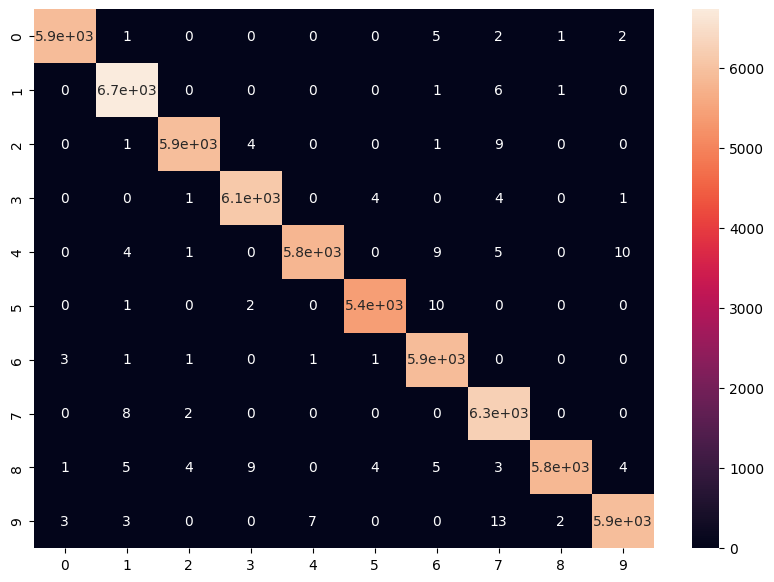

[ 각 클래스에 따른 정확도 ]
tensor([0.9981, 0.9988, 0.9975, 0.9984, 0.9950, 0.9976, 0.9988, 0.9984, 0.9940,
        0.9953])
[ 전체 평균 정확도 ]
tensor(0.9972)


In [29]:
# 혼동 행렬(Confusion Matrix) 시각화 (학습 데이터셋)
net = LeNet()
net = net.to(device)

file_name = "./checkpoint/LeNet_MNIST.pt"
checkpoint = torch.load(file_name)
net.load_state_dict(checkpoint['net'])

confusion_matrix = get_confusion_matrix(net, 10, train_loader)
print("[ 각 클래스당 데이터 개수 ]")
print(confusion_matrix.sum(1))

print("[ 혼동 행렬(confusion matrix) 시각화 ]")
# 행(row)은 실제 레이블, 열(column)은 모델이 분류한 레이블
res = pd.DataFrame(confusion_matrix.numpy(), index = [i for i in range(10)], columns = [i for i in range(10)])
plt.figure(figsize = (10, 7))
sn.heatmap(res, annot=True)
plt.show()

print("[ 각 클래스에 따른 정확도 ]")
# (각 클래스마다 정답 개수 / 각 클래스마다 데이터의 개수)
print(confusion_matrix.diag() / confusion_matrix.sum(1))

print("[ 전체 평균 정확도 ]")
print(confusion_matrix.diag().sum() / confusion_matrix.sum())

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[ 각 클래스당 데이터 개수 ]
tensor([ 980., 1135., 1032., 1010.,  982.,  892.,  958., 1028.,  974., 1009.])
[ 혼동 행렬(confusion matrix) 시각화 ]


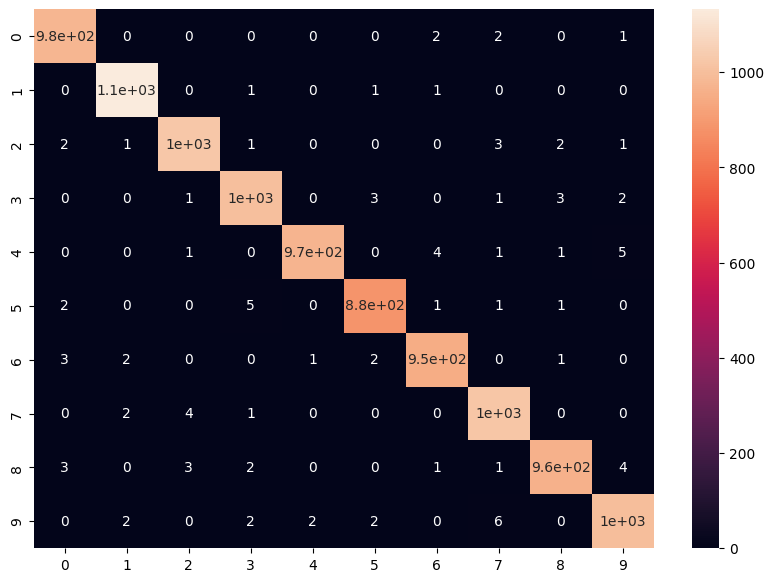

[ 각 클래스에 따른 정확도 ]
tensor([0.9949, 0.9974, 0.9903, 0.9901, 0.9878, 0.9888, 0.9906, 0.9932, 0.9856,
        0.9861])
[ 전체 평균 정확도 ]
tensor(0.9906)


In [30]:
# 혼동 행렬(Confusion Matrix) 시각화 (테스트 데이터셋)
net = LeNet()
net = net.to(device)

file_name = "./checkpoint/LeNet_MNIST.pt"
checkpoint = torch.load(file_name)
net.load_state_dict(checkpoint['net'])

confusion_matrix = get_confusion_matrix(net, 10, test_loader)
print("[ 각 클래스당 데이터 개수 ]")
print(confusion_matrix.sum(1))

print("[ 혼동 행렬(confusion matrix) 시각화 ]")
# 행(row)은 실제 레이블, 열(column)은 모델이 분류한 레이블
res = pd.DataFrame(confusion_matrix.numpy(), index = [i for i in range(10)], columns = [i for i in range(10)])
plt.figure(figsize = (10, 7))
sn.heatmap(res, annot=True)
plt.show()

print("[ 각 클래스에 따른 정확도 ]")
# (각 클래스마다 정답 개수 / 각 클래스마다 데이터의 개수)
print(confusion_matrix.diag() / confusion_matrix.sum(1))

print("[ 전체 평균 정확도 ]")
print(confusion_matrix.diag().sum() / confusion_matrix.sum())

### AlexNet 결과 분석

In [31]:
net = AlexNet()
net = net.to(device)

epoch = 10
learning_rate = 0.01
file_name = "AlexNet_MNIST.pt"

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

train_result = []
test_result = []

train_result.append(evaluate(net, 0, file_name, train_loader, "Train"))
test_result.append(evaluate(net, 0, file_name, test_loader, "Test"))

for i in range(epoch):
    train(net, i, optimizer, criterion, train_loader)
    train_acc, train_loss = evaluate(net, i + 1, file_name, train_loader, "Train")
    test_acc, test_loss = evaluate(net, i + 1, file_name, test_loader, "Test")

    state = {
        'net': net.state_dict()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print('Model Saved!')

    train_result.append((train_acc, train_loss))
    test_result.append((test_acc, test_loss))

[ Evaluate epoch: 0 ]
Dataset: Train


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Accuarcy: 9.751666666666667
Average loss: 0.017998644387722015
[ Evaluate epoch: 0 ]
Dataset: Test
Accuarcy: 9.74
Average loss: 0.02302675800323486
[Train epoch: 0]
Train accuarcy: 41.553333333333335
Train average loss: 0.011952106136083603
[ Evaluate epoch: 1 ]
Dataset: Train
Accuarcy: 95.255
Average loss: 0.0013067852015296619
[ Evaluate epoch: 1 ]
Dataset: Test
Accuarcy: 95.73
Average loss: 0.0015132976902648807
Model Saved!
[Train epoch: 1]
Train accuarcy: 58.608333333333334
Train average loss: 0.007179690647125244
[ Evaluate epoch: 2 ]
Dataset: Train
Accuarcy: 97.96833333333333
Average loss: 0.0006713098516066869
[ Evaluate epoch: 2 ]
Dataset: Test
Accuarcy: 98.21
Average loss: 0.0007793199746403843
Model Saved!
[Train epoch: 2]
Train accuarcy: 59.43833333333333
Train average loss: 0.006904676525791486
[ Evaluate epoch: 3 ]
Dataset: Train
Accuarcy: 98.715
Average loss: 0.00040063845285524927
[ Evaluate epoch: 3 ]
Dataset: Test
Accuarcy: 98.86
Average loss: 0.000448131283785915
Mod

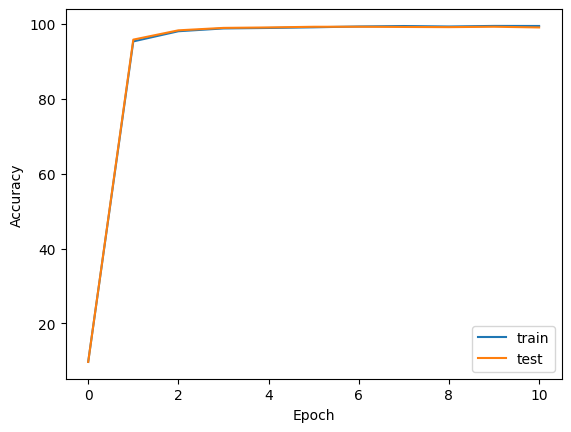

In [32]:
# 정확도(accuracy) 커브 시각화
plt.plot([i for i in range(epoch + 1)], [i[0] for i in train_result])
plt.plot([i for i in range(epoch + 1)], [i[0] for i in test_result])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["train", "test"])
plt.show()

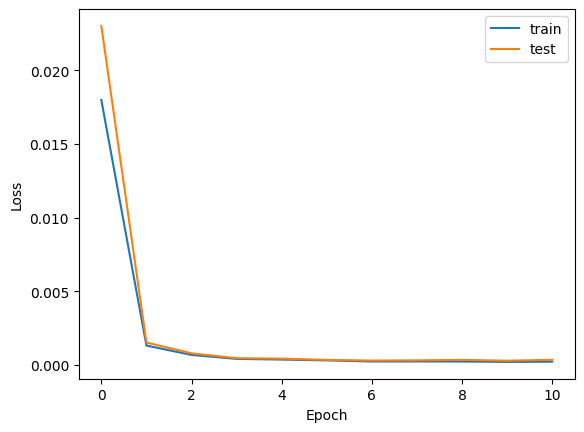

In [33]:
# 손실(loss) 커브 시각화
plt.plot([i for i in range(epoch + 1)], [i[1] for i in train_result])
plt.plot([i for i in range(epoch + 1)], [i[1] for i in test_result])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "test"])
plt.show()


[ 각 클래스당 데이터 개수 ]
tensor([5923., 6742., 5958., 6131., 5842., 5421., 5918., 6265., 5851., 5949.])
[ 혼동 행렬(confusion matrix) 시각화 ]


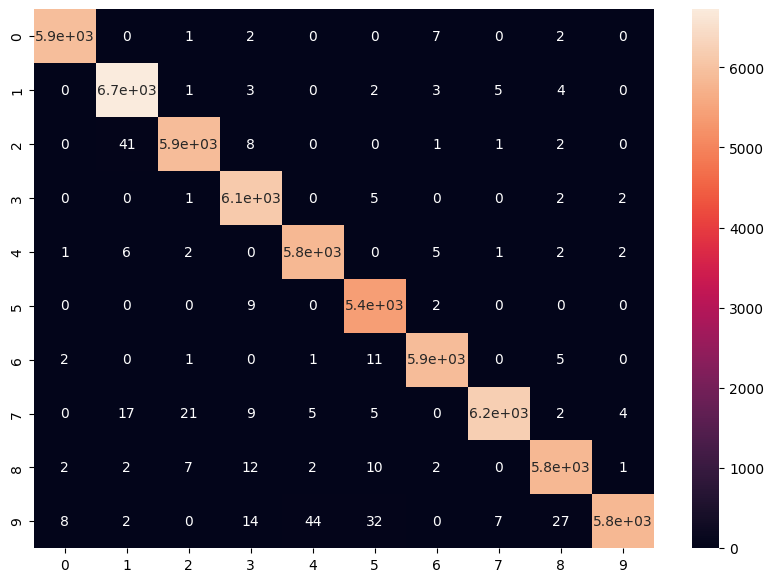

[ 각 클래스에 따른 정확도 ]
tensor([0.9980, 0.9973, 0.9911, 0.9984, 0.9967, 0.9980, 0.9966, 0.9899, 0.9935,
        0.9775])
[ 전체 평균 정확도 ]
tensor(0.9937)


In [34]:
# 혼동 행렬(Confusion Matrix) 시각화 (학습 데이터셋)
net = AlexNet()
net = net.to(device)

file_name = "./checkpoint/AlexNet_MNIST.pt"
checkpoint = torch.load(file_name)
net.load_state_dict(checkpoint['net'])

confusion_matrix = get_confusion_matrix(net, 10, train_loader)
print("[ 각 클래스당 데이터 개수 ]")
print(confusion_matrix.sum(1))

print("[ 혼동 행렬(confusion matrix) 시각화 ]")
# 행(row)은 실제 레이블, 열(column)은 모델이 분류한 레이블
res = pd.DataFrame(confusion_matrix.numpy(), index = [i for i in range(10)], columns = [i for i in range(10)])
plt.figure(figsize = (10, 7))
sn.heatmap(res, annot=True)
plt.show()

print("[ 각 클래스에 따른 정확도 ]")
# (각 클래스마다 정답 개수 / 각 클래스마다 데이터의 개수)
print(confusion_matrix.diag() / confusion_matrix.sum(1))

print("[ 전체 평균 정확도 ]")
print(confusion_matrix.diag().sum() / confusion_matrix.sum())

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[ 각 클래스당 데이터 개수 ]
tensor([ 980., 1135., 1032., 1010.,  982.,  892.,  958., 1028.,  974., 1009.])
[ 혼동 행렬(confusion matrix) 시각화 ]


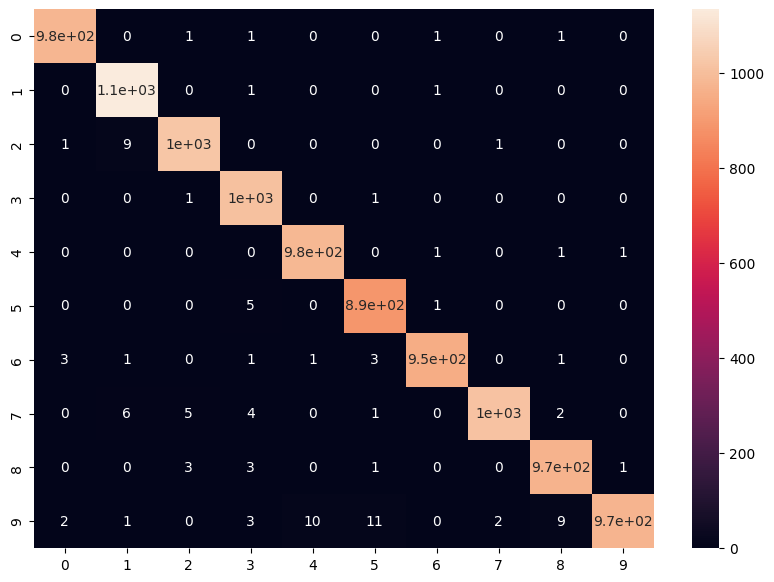

[ 각 클래스에 따른 정확도 ]
tensor([0.9959, 0.9982, 0.9893, 0.9980, 0.9969, 0.9933, 0.9896, 0.9825, 0.9918,
        0.9623])
[ 전체 평균 정확도 ]
tensor(0.9898)


In [35]:
# 혼동 행렬(Confusion Matrix) 시각화 (테스트 데이터셋)
net = AlexNet()
net = net.to(device)

file_name = "./checkpoint/AlexNet_MNIST.pt"
checkpoint = torch.load(file_name)
net.load_state_dict(checkpoint['net'])

confusion_matrix = get_confusion_matrix(net, 10, test_loader)
print("[ 각 클래스당 데이터 개수 ]")
print(confusion_matrix.sum(1))

print("[ 혼동 행렬(confusion matrix) 시각화 ]")
# 행(row)은 실제 레이블, 열(column)은 모델이 분류한 레이블
res = pd.DataFrame(confusion_matrix.numpy(), index = [i for i in range(10)], columns = [i for i in range(10)])
plt.figure(figsize = (10, 7))
sn.heatmap(res, annot=True)
plt.show()

print("[ 각 클래스에 따른 정확도 ]")
# (각 클래스마다 정답 개수 / 각 클래스마다 데이터의 개수)
print(confusion_matrix.diag() / confusion_matrix.sum(1))

print("[ 전체 평균 정확도 ]")
print(confusion_matrix.diag().sum() / confusion_matrix.sum())